In [63]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

## Data Loading 

In [65]:
df = pd.read_excel("Online Retail.xlsx")
print("Number of rows in the dataset: ", df.shape[0])
print("Number of columns in the dataset: ", df.shape[1])

Number of rows in the dataset:  541909
Number of columns in the dataset:  8


In [66]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Inspection & Data Cleaning

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [69]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [70]:
cancelled = df[df['InvoiceNo'].astype(str).str.startswith('C')]
negative_price = df[df['UnitPrice'] < 0]
negative_quantity = df[df['Quantity'] < 0]
print("Number of cancelled orders: ", cancelled.shape[0])
print("Number of orders with price corrections: ", negative_price.shape[0])
print("Number of rows with negative 'Quantity': ", negative_quantity.shape[0])

Number of cancelled orders:  9288
Number of orders with price corrections:  2
Number of rows with negative 'Quantity':  10624


The dataset contains negative values for both Quantity and UnitPrice. Negative values for Quantity likely represent canceled orders, which we can identify by checking if InvoiceNo starts with the letter 'C'. These transactions are separated into a new dataframe for deeper insights, such as analyzing patterns in cancellations, frequent reasons, or products that are often returned.

Negative values for UnitPrice might indicate corrections or anomalies in pricing, which could distort the analysis. These entries have been removed to ensure the integrity and accuracy of our findings, as retaining them could bias metrics like average sales or trends.

In [72]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

Lastly, we check for the number of duplicated orders and remove any missing values. 

In [74]:
print("Number of duplicated orders:", len(df[df.duplicated()]))

Number of duplicated orders: 5226


In [75]:
df.drop_duplicates(inplace = True)
df = df.dropna()

In [76]:
print("Number of rows in the dataset: ", df.shape[0])

Number of rows in the dataset:  392692


In [77]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Feature Engineering

In [79]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#### Calculating Total Sales

In [81]:
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

#### Adding Hour, Day, Month, and Year Features 

In [83]:
df['Hour'] = df['InvoiceDate'].dt.hour
df['Day'] = df['InvoiceDate'].dt.day_name()
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceYear']  = df['InvoiceDate'].dt.year
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Hour,Day,InvoiceMonth,InvoiceYear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,8,Wednesday,12,2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,Wednesday,12,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,8,Wednesday,12,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,Wednesday,12,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,Wednesday,12,2010


## Product Analysis

### Monthly Sales Trend

In [156]:
def most_purchased(month):
    monthly_data = df[df['InvoiceMonth'] == month]
    top_product = (monthly_data.groupby('Description')['Quantity']
                   .sum().sort_values(ascending=False).idxmax())
    return top_product

monthly_sales = df.groupby('InvoiceMonth')['TotalSales'].sum().reset_index()
monthly_sales['MonthName'] = monthly_sales['InvoiceMonth'].apply(lambda x: calendar.month_name[x])
monthly_sales['MostPurchasedProduct'] = monthly_sales['InvoiceMonth'].apply(most_purchased)
monthly_sales

,InvoiceMonth,TotalSales,MonthName,MostPurchasedProduct
0,1,568101.310,January,MEDIUM CERAMIC TOP STORAGE JAR
1,2,446084.920,February,EMPIRE DESIGN ROSETTE
2,3,594081.760,March,JUMBO BAG RED RETROSPOT
3,4,468374.331,April,WORLD WAR 2 GLIDERS ASSTD DESIGNS
4,5,677355.150,May,SMALL POPCORN HOLDER
5,6,660046.050,June,JUMBO BAG RED RETROSPOT
6,7,598962.901,July,WORLD WAR 2 GLIDERS ASSTD DESIGNS
7,8,644051.040,August,ASSORTED COLOUR BIRD ORNAMENT
8,9,950690.202,September,JUMBO BAG RED RETROSPOT
9,10,1035642.450,October,WORLD WAR 2 GLIDERS ASSTD DESIGNS


Since we have incomplete data in 2010, we will avoid talking about 'TotalSales' in general as it will create inaccurate insight.

**1. Most Purchased Products**:
- Certain products are repeatedly the most purchased in multiple months, indicating strong customer preferences: "JUMBO BAG RED RETROSPOT" is the most purchased product in March, June, and September.
- "WORLD WAR 2 GLIDERS ASST'D DESIGNS" appears as the most purchased product in April, July, and October.
- Other unique products like "MEDIUM CERAMIC TOP STORAGE JAR" (January) and "RABBIT NIGHT LIGHT" (November) dominate specific months.

**2. Seasonal Patterns**:
- The most purchased products vary seasonally, likely reflecting changes in customer demand or promotional strategies (e.g., "PAPER CRAFT, LITTLE BIRDIE" in December).

In [87]:
sns.set_theme(style="whitegrid", context="talk")
custom_palette = ["#2A9D8F", "#E9C46A", "#F4A261"]

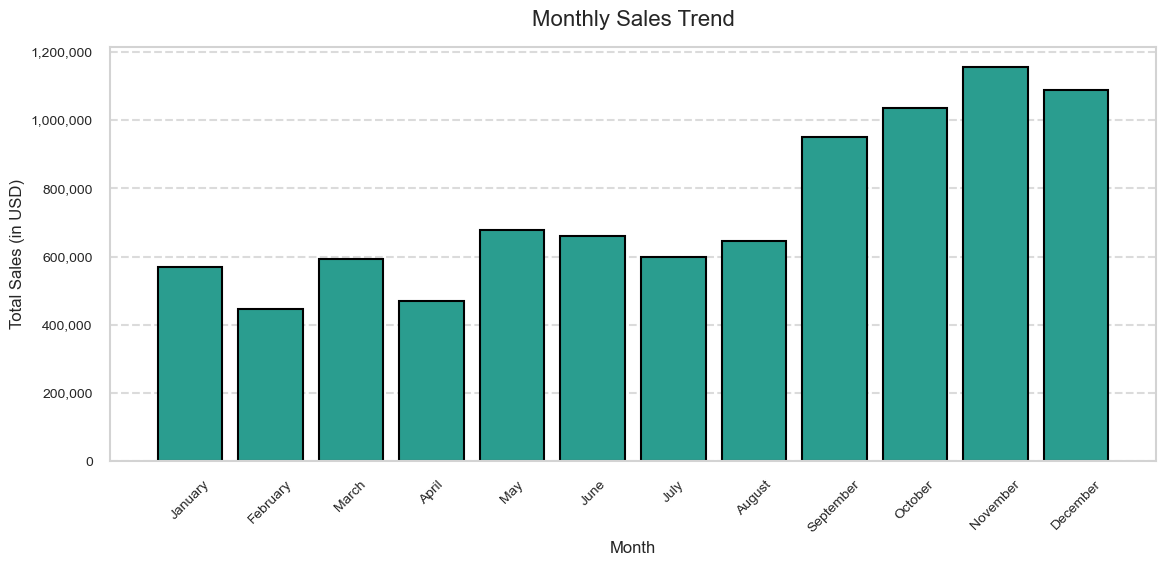

In [154]:
def format_y_axis(value, tick_number):
    return f'{int(value):,}'

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(
    monthly_sales['MonthName'],
    monthly_sales['TotalSales'],
    color=custom_palette[0],  
    edgecolor='black',
    width=0.8
)

ax.set_title('Monthly Sales Trend', fontsize=16, pad=15)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Total Sales (in USD)', fontsize=12)
ax.tick_params(axis='x', labelrotation=45, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax.yaxis.set_major_formatter(FuncFormatter(format_y_axis))
ax.grid(False)

ax.grid(axis='y', linestyle='--', alpha=0.7)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('lightgrey')
    spine.set_linewidth(1.5)

plt.tight_layout()

plt.show()

#### Seasonal Peak in Q4

Sales are lower in February and rebound in March, suggesting that early‐year marketing efforts could help smooth out demand. The highest sales volumes occur toward the end of the year, with a notable spike in September through December, indicating strong holiday/seasonal demand.

### Top 10 Products in 2010 (December Only)

In [92]:
top_2010_products = df[df['InvoiceYear'] == 2010]
top_products_2010 = (
    top_2010_products.groupby('Description')['Quantity'].sum()
    .nlargest(10)
    .reset_index()
)

top_2010_months = []
for product in top_products_2010['Description']:
    product_data = top_2010_products[top_2010_products['Description'] == product]
    top_month = (
        product_data.groupby('InvoiceMonth')['Quantity'].sum()
        .idxmax()
    )
    top_2010_months.append(calendar.month_name[top_month])

top_products_2010['MostPurchasedMonth'] = top_2010_months
top_products_2010

,Description,Quantity,MostPurchasedMonth
0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5139,December
1,WHITE HANGING HEART T-LIGHT HOLDER,3611,December
2,PACK OF 72 RETROSPOT CAKE CASES,3572,December
3,HAND WARMER BABUSHKA DESIGN,3341,December
4,MINI PAINT SET VINTAGE,2700,December
5,PACK OF 12 LONDON TISSUES,2656,December
6,GROW A FLYTRAP OR SUNFLOWER IN TIN,2616,December
7,ASSORTED COLOUR BIRD ORNAMENT,2259,December
8,CREAM HEART CARD HOLDER,2253,December
9,RED HARMONICA IN BOX,2157,December


Since only December data is available in 2010, it makes sense that all products are most purchased in December. Furthermore, we can see that:
- **Gift‐oriented Items**: The products (e.g., cake cases, T‐light holders, novelty gliders) appear tied to gifting/seasonal events, reinforcing the need to plan inventories around holiday spikes.
- **Dominant Leader**: “WORLD WAR 2 GLIDERS ASSTD DESIGNS” held a clear lead, suggesting it was either a trend item or consistently in high demand in 2010.

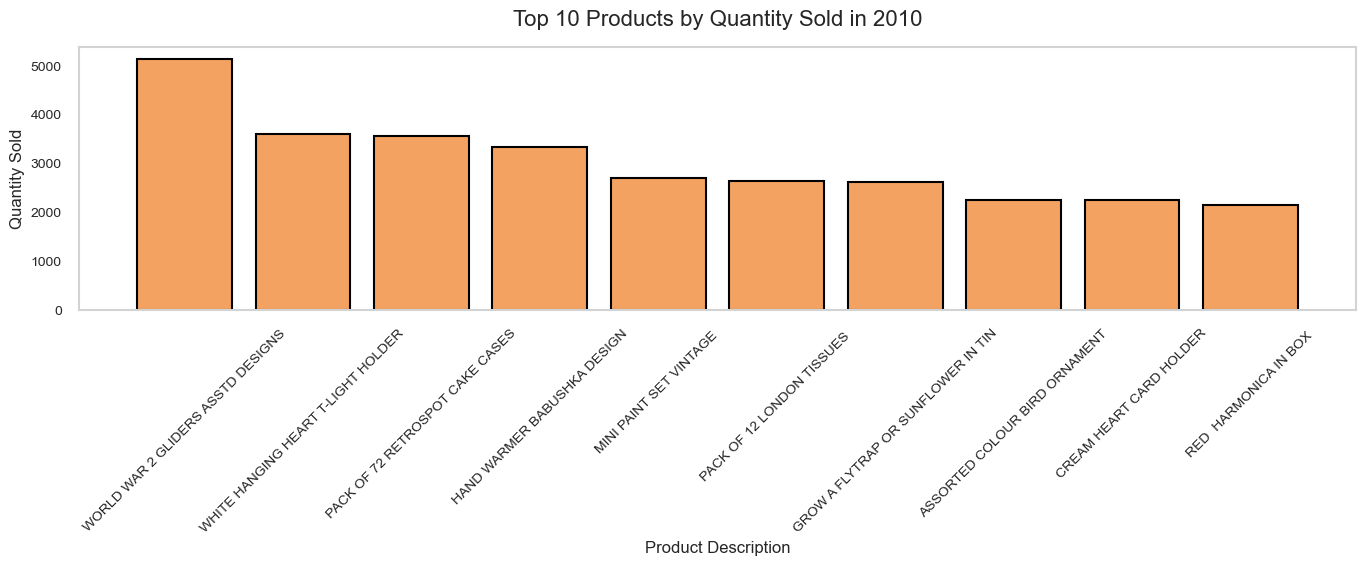

In [94]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.bar(
    top_products_2010['Description'],
    top_products_2010['Quantity'],
    color=custom_palette[2],  
    edgecolor='black',
    width=0.8
)

ax.set_title('Top 10 Products by Quantity Sold in 2010', fontsize=16, pad=15)
ax.set_xlabel('Product Description', fontsize=12)
ax.set_ylabel('Quantity Sold', fontsize=12)
ax.tick_params(axis='x', labelrotation=45, labelsize=10, direction='out')
ax.tick_params(axis='y', labelsize=10)

ax.grid(False)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('lightgrey')
    spine.set_linewidth(1.5)

plt.tight_layout()

plt.show()

### Top 10 Products in 2011

In [96]:
top_2011_products = df[df['InvoiceYear'] == 2011]
top_products_2011 = (
    top_2011_products.groupby('Description')['Quantity'].sum()
    .nlargest(10)
    .reset_index()
)

top_2011_months = []
for product in top_products_2011['Description']:
    product_data = top_2011_products[top_2011_products['Description'] == product]
    top_month = (
        product_data.groupby('InvoiceMonth')['Quantity'].sum()
        .idxmax()
    )
    top_2011_months.append(calendar.month_name[top_month])

top_products_2011['MostPurchasedMonth'] = top_2011_months
top_products_2011

,Description,Quantity,MostPurchasedMonth
0,"PAPER CRAFT , LITTLE BIRDIE",80995,December
1,MEDIUM CERAMIC TOP STORAGE JAR,77916,January
2,WORLD WAR 2 GLIDERS ASSTD DESIGNS,49180,April
3,JUMBO BAG RED RETROSPOT,44022,November
4,WHITE HANGING HEART T-LIGHT HOLDER,33095,January
5,ASSORTED COLOUR BIRD ORNAMENT,33004,August
6,POPCORN HOLDER,30919,November
7,PACK OF 72 RETROSPOT CAKE CASES,30098,March
8,RABBIT NIGHT LIGHT,27153,November
9,MINI PAINT SET VINTAGE,23376,September


- **Shifting Best‐Sellers**: New items (e.g., “PAPER CRAFT, LITTLE BIRDIE” and “MEDIUM CERAMIC TOP STORAGE JAR”) replaced some of 2010’s top sellers, implying changing consumer tastes or successful product expansions.
- **Month‐by‐Month Variability**: The peak month for each item varies (e.g., January for the storage jar, April for the gliders, etc.), signaling more varying levels of demand throughout the year and a broader marketing opportunity.

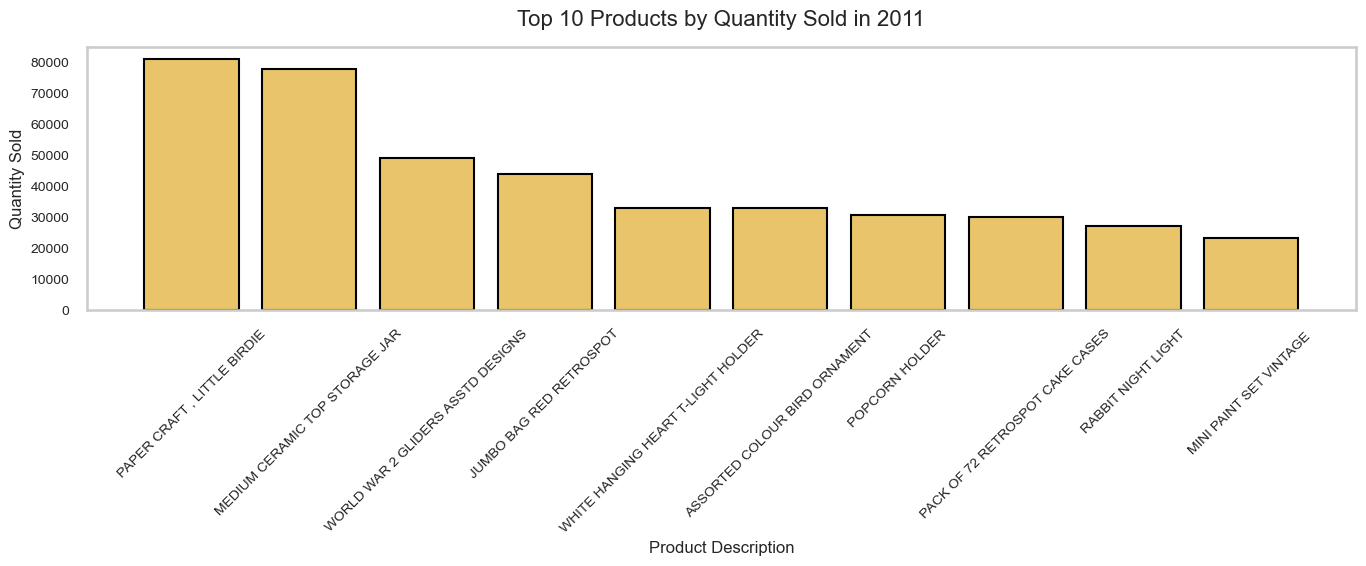

In [98]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.bar(
    top_products_2011['Description'],
    top_products_2011['Quantity'],
    color=custom_palette[1],  
    edgecolor='black',
    width=0.8
)

ax.set_title('Top 10 Products by Quantity Sold in 2011', fontsize=16, pad=15)
ax.set_xlabel('Product Description', fontsize=12)
ax.set_ylabel('Quantity Sold', fontsize=12)
ax.tick_params(axis='x', labelrotation=45, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

ax.grid(False)

plt.tight_layout()

plt.show()

## Customer Segmentation with K-means Clustering

### RFM (Recency, Frequency, Monetary) Metrics 

In [101]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (pd.Timestamp.now() - x.max()).days,  
    'InvoiceNo': 'count',                                         
    'TotalSales': 'sum'                                          
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSales': 'Monetary'
})

### Data Normalization

In [103]:
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm)

### Calculating the optimal number of clusters

In [105]:
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    inertia.append(kmeans.inertia_)

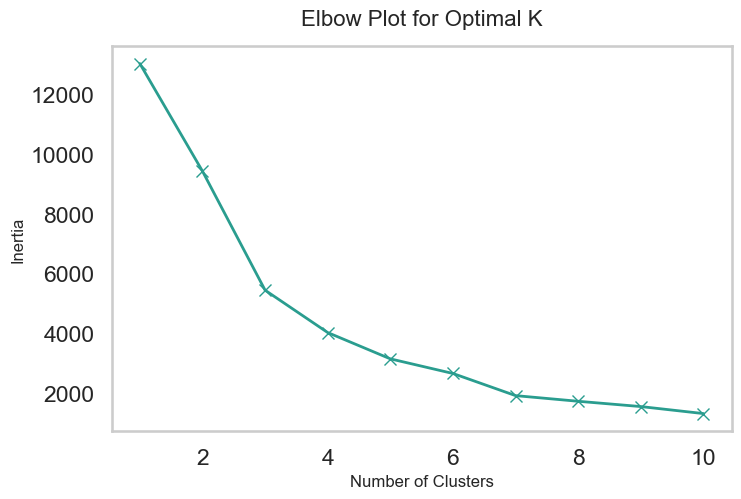

In [106]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(K, inertia, marker='x', linestyle='-', color=custom_palette[0], linewidth=2, markersize=8)
ax.set_title('Elbow Plot for Optimal K', fontsize=16, pad=15)
ax.set_xlabel('Number of Clusters', fontsize=12)
ax.set_ylabel('Inertia', fontsize=12)

ax.grid(False)

plt.show()

Based on the plot above, the optimal number of clusters is K = 4, where the reduction in inertia slows down noticeably after that point.

In [108]:
optimal_k = 4 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_normalized)

### Cluster Analysis

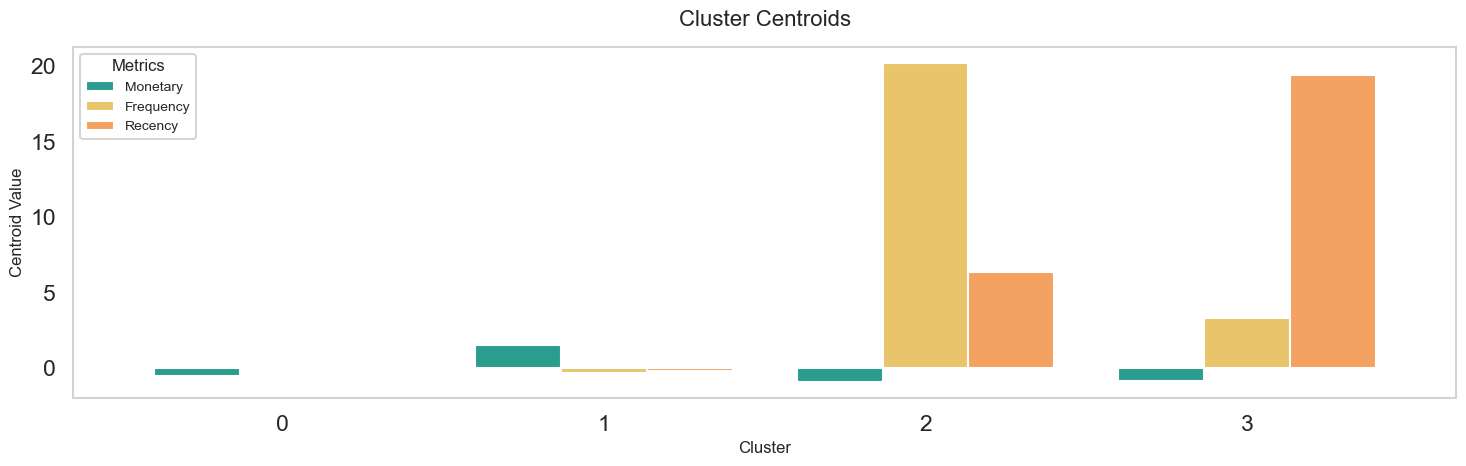

In [110]:
var = ['Monetary', 'Frequency', 'Recency']
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=var)

fig, ax = plt.subplots(figsize=(15, 5))

centroids.plot(
    kind='bar',
    ax=ax,
    color=custom_palette,
    width=0.8
)

ax.grid(False)

ax.set_title('Cluster Centroids', fontsize=16, pad=15)
ax.set_ylabel('Centroid Value', fontsize=12)
ax.set_xlabel('Cluster', fontsize=12)

ax.set_xticklabels(centroids.index, rotation=0)

for spine in ax.spines.values():
    spine.set_visible(True)  
    spine.set_edgecolor('lightgrey')  
    spine.set_linewidth(1.5)  

legend = ax.legend(
    title='Metrics',
    loc='upper left',
    fontsize=10,
    title_fontsize=12
)

plt.tight_layout()

plt.show()

In [111]:
print(rfm['Cluster'].value_counts())

Cluster
0    3246
1    1079
3       7
2       6
Name: count, dtype: int64


### Key Observations of Customer Segmentation

**Cluster 0**: 
 - Typically below average per‐customer spending, since the cluster centroid for Monetary is below zero.
 - Frequency and Recency is around the overall mean.
 - These customers spend a bit less than average per purchase but buy with about average frequency and recency. In raw (non‐standardized) terms, Cluster 0’s totals may appear large simply because it contains the most customers, but at an individual level, spending is somewhat modest.

**Cluster 1**: 
 - Monetary value is above average compared to other clusters .
 - Frequency and recency is lower than average.
 - This segment tends to spend more per transaction than the mean, but they do not buy as frequently or as recently as other groups. They may be higher‐ticket shoppers who purchase infrequently.

**Cluster 2**: 
 - Has a very high centroid for Frequency and moderate recency.
 - Monetary value is below average.
 - On a per‐customer basis, these buyers place many orders (high Frequency), but each order is typically for a lower amount (below‐average Monetary). In the raw charts, this cluster has relatively small totals (e.g., total Monetary) because the group itself is small (only 7 customers). Individually, though, they are very active purchasers.
 
**Cluster 3**: 
 - A moderate or modest Monetary value relative to the mean.
 - A lower Frequency centroid compared to Cluster 2 but higher than average compared to Clusters 0 and 1.
 - A high Recency, suggesting these are very recent purchasers on average.
 - These customers buy fairly often and very recently, with spending levels around the overall mean. Though their total Recency contribution in raw terms is not huge (due to smaller cluster size), their per‐customer recency is among the highest.

### Suggestions for Targeted Strategies

**Cluster 0**: 
1. Upselling & Cross-Selling Campaign:
   - Offer product bundles or “frequently bought together” suggestions.
   - Provide small add-ons (“complete your purchase” deals) to gently increase average order value, improving the Monetary component.
2. Targeted Email Promotions:
   - Highlight special offers with slightly higher price‐point products, to increase attraction for higher value items.

**Cluster 1**: 
1. Loyalty Initiatives:
   - Send “We Miss You” campaigns to encourage them to come back sooner.
   - Offer membership programs and VIP perks to products/services, appealing to their higher spending power.
2. Referral Programs
   - High spenders often have influential networks; provide referral discounts or rewards for bringing new customers with a similar background.

**Cluster 2**: 
1. Subscription Offers:
   - Given their high frequency, a subscription model might appeal to their habit of regular purchasing.
   - Offer a recurring purchase option for frequently bought items.
2. Cross‐Category Promotion
   - Introduce them to other product categories.
   - Leverage frequency with in‐cart recommendations (“customers like you also bought…”).
 
**Cluster 3**: 
1. Build Loyalty Through Timely Follow‐Up
   - Offer a loyalty sign‐on bonus, encouraging them to keep shopping with the store and increasing frequency.
2. Encourage Repeat Purchases Quickly
   - Offer a “next purchase discount” or “buy again within 30 days to receive…” incentive to leverage the recency pattern.
   - Leverage push notifications or personalized emails shortly after their last purchase to maintain momentum.